## Part II : Creating a single layer neural net manually

In [31]:
import math
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# excetions show up normally
%xmode plain

# plots show up inline
%matplotlib inline

def get_device(no_gpu=False):
    """
    Returns one of cuda / mps / cpu based on availablity
    """
    if no_gpu is True:
        return torch.device("cpu")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")


# Choose the default device
no_gpu = False
default_device = get_device(no_gpu)


# Needed to import modules from src
import sys
sys.path.append('..')


# Get Project Root (needed for reading config)
import os
projectRoot = os.path.dirname(os.getcwd())
print(projectRoot)

Exception reporting mode: Plain
e:\Karpathy-Makemore


#### Load Data

In [32]:
from src.loadData import get_everything, start_ch
all_data, vocab, stoi, itos = get_everything(projectRoot)

print(f"Vocab Size: {len(vocab)}")
all_data[:10]

Vocab Size: 27


['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

#### Create Training Samples

In [33]:
xs, ys = [],  []

for name in all_data:
    annotated_name = [start_ch] + list(name) + [start_ch]
    for c1, c2 in zip(annotated_name, annotated_name[1:]):
        xs.append(stoi[c1])
        ys.append(stoi[c2])

xs, ys = torch.tensor(xs, device=default_device), torch.tensor(ys, device=default_device)

#### Use One Hot Encoding on xs to make it pluggable to the NN

In [34]:
X = F.one_hot(xs, num_classes=len(vocab)).float()
print(f"X shape:{X.shape}")
X[:5, :]

X shape:torch.Size([228146, 27])


tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')

## Single Layer NN

#### Create the weights

In [60]:
g = torch.Generator(device=default_device).manual_seed(2147483647)

W = torch.randn(len(vocab), len(vocab), device=default_device, generator=g)
b = torch.randn(len(vocab), device=default_device, generator=g)

learning_rate = 0.1
minibatch_size = 1000
lossi = []

parameters = [W, b]
for p in parameters:
    p.requires_grad = True

#### NN training Loop (using minibatches and softmax, NO tanh or an activation function)

In [61]:
%%time

epochs = 20000
for epoch in range(epochs):

    # Create Minibatch
    ix = torch.randint(high=X.shape[0], size=(minibatch_size,), generator=g, device=default_device)
    Xtr = X[ix]
    Ytr = ys[ix]

    # Forward Pass
    logits = Xtr @ W + b
    
    # softmax step
    counts = torch.exp(logits)
    probs = counts / counts.sum(dim=1, keepdim=True)

    # Negative Log likelihood loss
    loss = (-1) * torch.log(probs[:, Ytr]).mean() 

    # Added regularization
    loss += ((W ** 2).mean() + (b **2).mean())

    if epoch % 1000 == 0:
        print(f"epoch:{epoch} \t loss: {loss.item()}")

    lossi.append(loss.item())

    # Zero Grad
    for p in parameters:
        p.grad = None

    # Backward Pass
    loss.backward()

    # Update params
    for p in parameters:
        p.data -= (learning_rate * p.grad)


epoch:0 	 loss: 6.2238287925720215
epoch:1000 	 loss: 3.673457384109497
epoch:2000 	 loss: 3.3410048484802246
epoch:3000 	 loss: 3.152890205383301
epoch:4000 	 loss: 3.0996384620666504
epoch:5000 	 loss: 3.05730938911438
epoch:6000 	 loss: 3.0494396686553955
epoch:7000 	 loss: 3.066816568374634
epoch:8000 	 loss: 2.9954073429107666
epoch:9000 	 loss: 3.0059876441955566
epoch:10000 	 loss: 3.019606113433838
epoch:11000 	 loss: 3.0275237560272217
epoch:12000 	 loss: 3.021897077560425
epoch:13000 	 loss: 3.013688564300537
epoch:14000 	 loss: 3.0649428367614746
epoch:15000 	 loss: 3.0443625450134277
epoch:16000 	 loss: 3.014890432357788
epoch:17000 	 loss: 3.016953945159912
epoch:18000 	 loss: 3.0466935634613037
epoch:19000 	 loss: 3.001441240310669
CPU times: total: 17.2 s
Wall time: 17.4 s


#### Plot training error (averaged over 100 iterations)

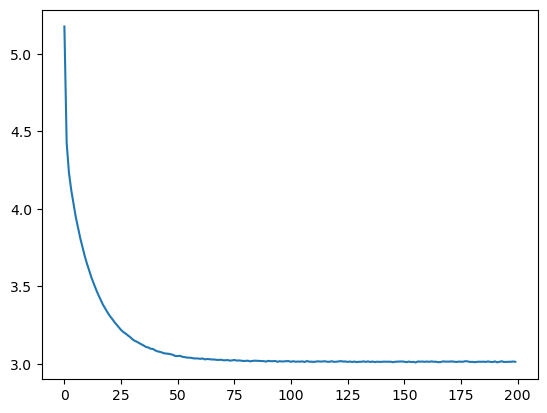

In [62]:
plt.plot(torch.tensor(lossi).view(-1, 100).mean(1))
plt.show()